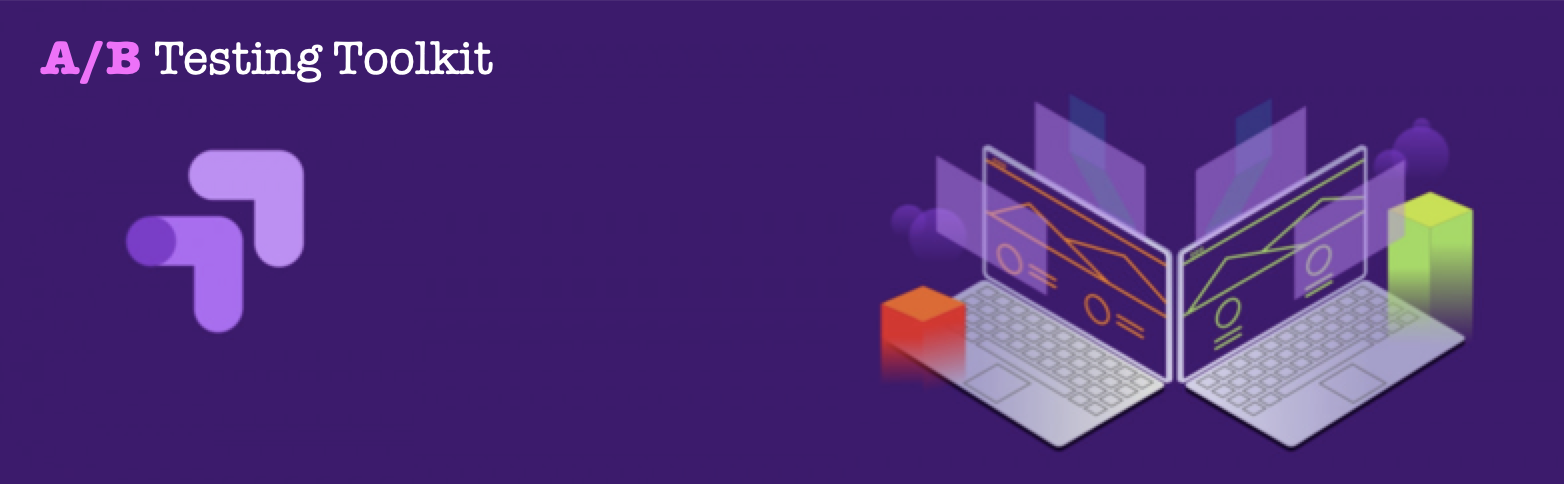

# Bland-Altman A/B Test Plot

In [2]:
## Import packages

import pandas as pd
import seaborn as sb
import matplotlib as plt
import numpy as np
import statistics
from scipy import stats
from statannot import add_stat_annotation
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import warnings
import statistics
import scipy
import pyCompare

In [3]:
## Turn off warnings

warnings.filterwarnings("ignore")

In [29]:
## Load in data

local = 'ab_test_data.csv'
df = pd.read_csv(local, encoding= 'unicode_escape')
df.head(100)

,user_experience,exp_metric
0,EXP=ipltv_af05_remove_preroll::removed,1
1,EXP=ipltv_af05_remove_preroll::removed,2
2,EXP=ipltv_af05_remove_preroll::removed,1
3,EXP=ipltv_af05_remove_preroll::removed,2
4,EXP=ipltv_af05_remove_preroll::removed,1
...,...,...
95,EXP=ipltv_af05_remove_preroll::removed,1
96,EXP=ipltv_af05_remove_preroll::removed,1
97,EXP=ipltv_af05_remove_preroll::removed,2
98,EXP=ipltv_af05_remove_preroll::removed,1


In [30]:
## Groupby user_experience

df_grouped = df.groupby(['user_experience']).mean()

# Cleaning data - outliers

In [31]:
## Print standard deviation of overall plays per browser

std = statistics.stdev(df.exp_metric)
print ("Standard deviation of experiment metric is % s"
    % round(std,4))

Standard deviation of experiment metric is 1.0963


In [32]:
## Print the threshold/cut-off for data that needs to be removed from the overall data-frame

outliers = 3 * std

print("Remove data from data-frame that is % s above the mean of the data"
     % round(outliers,4))

Remove data from data-frame that is 3.2888 above the mean of the data


In [33]:
## Create new data-frame with data below the standard deviation (+ 3 SD) values

df_filtered = df[(df['exp_metric'] <  outliers)]
df_filtered.groupby(['user_experience']).mean()

,exp_metric
user_experience,
EXP=ipltv_af05_remove_preroll::control,1.331396
EXP=ipltv_af05_remove_preroll::removed,1.334165


# Significance testing

In [34]:
mc = MultiComparison(df_filtered['exp_metric'], df_filtered['user_experience'])
mc_results = mc.tukeyhsd()
print(mc_results)

                               Multiple Comparison of Means - Tukey HSD, FWER=0.05                               
                group1                                 group2                 meandiff p-adj  lower  upper reject
-----------------------------------------------------------------------------------------------------------------
EXP=ipltv_af05_remove_preroll::control EXP=ipltv_af05_remove_preroll::removed   0.0028 0.0168 0.0005 0.005   True
-----------------------------------------------------------------------------------------------------------------


# Visualisations

In [35]:
# Take random samples from each experimental condition in order to transform to normal distribution to plot distributions

results = [] # create an empty list into which I insert the sampled means
random_state = np.arange(0,1500) # random seeds for reproducibility


# sample with replacement using 50% of the data; do this 1000 times
# and append the mean seeling time to the list ‘results’



for i in range(1500):
 sample = df_filtered.sample(frac=0.5, replace=True, random_state=random_state[i]).groupby(by='user_experience')['exp_metric'].mean()
 results.append(sample)
dist_samples_bland_alt = pd.DataFrame(results)
dist_samples_bland_alt.head(100)

user_experience,EXP=ipltv_af05_remove_preroll::control,EXP=ipltv_af05_remove_preroll::removed
exp_metric,1.331591,1.333472
exp_metric,1.331564,1.335336
exp_metric,1.331087,1.333061
exp_metric,1.328960,1.333236
exp_metric,1.330826,1.331707
...,...,...
exp_metric,1.331201,1.335069
exp_metric,1.331855,1.334726
exp_metric,1.331418,1.334655
exp_metric,1.329782,1.333437


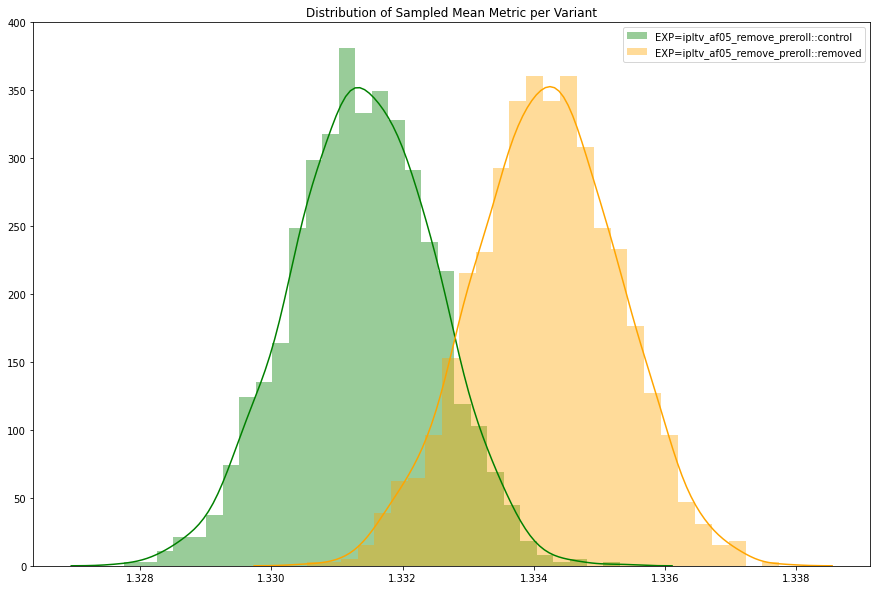

In [39]:
## Plot sampled means for metric in distribution plot

plt.figure(figsize=(15,10))
sb.distplot(dist_samples_bland_alt[['EXP=ipltv_af05_remove_preroll::control']], hist=True, color='green')
sb.distplot(dist_samples_bland_alt[['EXP=ipltv_af05_remove_preroll::removed']], hist=True, color='orange')
plt.legend(labels=['EXP=ipltv_af05_remove_preroll::control','EXP=ipltv_af05_remove_preroll::removed'])
plt.title("Distribution of Sampled Mean Metric per Variant")
plt.show()

# Bland-Altman

In [37]:
## Create two columns (x,y)

# x = average of two variants 

dist_samples_bland_alt['x'] = ((dist_samples_bland_alt['EXP=ipltv_af05_remove_preroll::control'] + dist_samples_bland_alt['EXP=ipltv_af05_remove_preroll::removed'])/2)

# y = the difference between the control and variant

dist_samples_bland_alt['y'] = ((dist_samples_bland_alt['EXP=ipltv_af05_remove_preroll::control'] - dist_samples_bland_alt['EXP=ipltv_af05_remove_preroll::removed'])*100)/((dist_samples_bland_alt['EXP=ipltv_af05_remove_preroll::control'] + dist_samples_bland_alt['EXP=ipltv_af05_remove_preroll::removed'])/2)

# Print average difference and upper and lower bound of confidence interval

print('Mean of y: '+ str(dist_samples_bland_alt['y'].mean()))
print('Upper-bound at 95%: ' + str(dist_samples_bland_alt['y'].mean() + 1.96 * dist_samples_bland_alt['y'].std()))
print('Lower-bound at 95%: ' + str(dist_samples_bland_alt['y'].mean() - 1.96 * dist_samples_bland_alt['y'].std()))

# Print head of data-frame

dist_samples_bland_alt.head(5)


Mean of y: -0.21035912560595488
Upper-bound at 95%: 0.020865163346318827
Lower-bound at 95%: -0.4415834145582286


user_experience,EXP=ipltv_af05_remove_preroll::control,EXP=ipltv_af05_remove_preroll::removed,x,y
exp_metric,1.331591,1.333472,1.332532,-0.141153
exp_metric,1.331564,1.335336,1.333450,-0.282907
exp_metric,1.331087,1.333061,1.332074,-0.148260
exp_metric,1.328960,1.333236,1.331098,-0.321292
exp_metric,1.330826,1.331707,1.331266,-0.066125


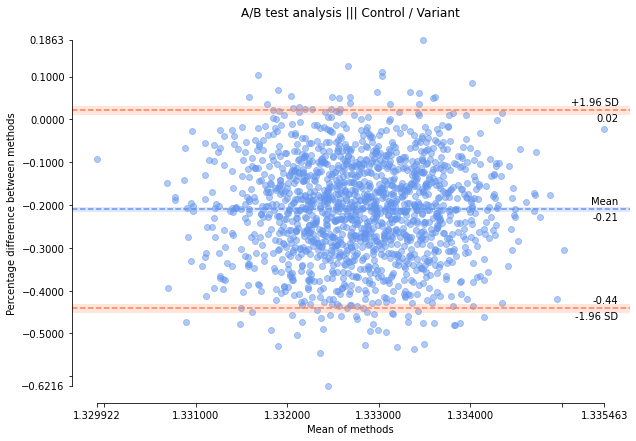

In [38]:
## Plot Bland-Altman

pyCompare.blandAltman(dist_samples_bland_alt['EXP=ipltv_af05_remove_preroll::control'],
                      dist_samples_bland_alt['EXP=ipltv_af05_remove_preroll::removed'], percentage = True, 
                      title='A/B test analysis ||| Control / Variant')